In [52]:
%matplotlib inline
import msprime
import numpy as np
import seaborn as sns
import multiprocessing

from IPython.display import SVG


## Running simulations

At the simplest level, coalescent simulation is about generating trees. These trees represent the simulated history of a sample of individuals drawn from an idealised population (in later sections we show how to vary the properites of this idealised population). The function ``msprime.simulate`` runs these simulations, and the parameters that we provide to this function determine the exact simulation that we run. It returns a ``TreeSequence`` object, which represents the full simulated history of the sample. In later sections we discuss the effects of recombination, when this ``TreeSequence`` contains a list of correlated trees. For now, we assume that there is no recombinations, and we use the method ``first()`` to obtain the tree object from this tree sequence. For example, here we simulate a history for a sample of three chromosomes:

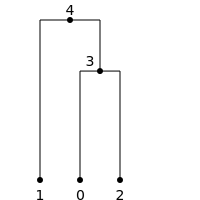

In [33]:
ts = msprime.simulate(3)
tree = ts.first()
SVG(tree.draw())

In this tree we have 5 nodes. Nodes 0, 1 and 2 are *leaves*, and represent our samples. Node 3 is an *internal* node, and is the parent of 0 and 1. Node 4 is also an internal node, and is the root of the tree. In mpsrime, we always refer to nodes by their integer IDs and obtain information about these nodes by calling methods on the tree object. For example the code ``tree.children(4)`` will return the tuple ``(2, 3)`` here, as these are the node IDs of the children of the root node. Similarly, ``tree.parent(0)`` will return ``3``.

The height of nodes in a tree are determined by their *time*; this is how long ago the ancestor that corresponds the node was born. So, contemporary samples always have a node time of zero, and time values increase as we go upwards in the tree (and further back in time). Times in msprime are always measured in *generations*. 

When we run a single simulation, the resulting tree is a single random sample from the probability distribution of coalescent trees. Since a single random draw from any distribution is not usually informative, we nearly always need to run many different *replicate* simulations to obtain useful information. This simplest way to do this in msprime is to use the ``num_replicates`` argument.

In [40]:
N = 1000
mean_T_mrca = 0
for ts in msprime.simulate(10, num_replicates=N):
    tree = ts.first()
    mean_T_mrca += tree.time(tree.root)
mean_T_mrca = mean_T_mrca / N
mean_T_mrca

3.5490350726811175

In this example we run 1000 independent replicates of the coalescent for a sample of 10 chromosomes, and compute the mean time to the most recent common ancestor of the entire sample, or equivalently the root of the tree. (The value we obtain is a highly unrealistic 3.5 generations in the past; however, this is unsurprising since we have specified a highly unrealistic population model. See the next for more details on how to specify population models and interpret simulation times.) The ``simulate`` function behaves slightly differently when it is called with the ``num_replicates`` argument: rather than returning a single tree sequence we return an *iterator* over the individual replicates. What this essentially means is that we can use the convenient **for** loop construction to consider each simulation in turn, but without actually storing all these simulations. As a result, we can run millions of replicates using this method if needs be without using any extra storage.

When simulating coalescent trees, we are often interested in more than just the mean of the distribution of some statistic. Rather than compute the various summaries by hand (as we have done for the mean in the last example), it is much more convenient to store the result for each replicate and analyse this array after the simulations have completed. For example:

In [36]:
N = 1000
T_mrca = np.zeros(N)
for j, ts in enumerate(msprime.simulate(10, num_replicates=N)):
    tree = ts.first()
    T_mrca[j] = tree.time(tree.root)
np.mean(T_mrca), np.var(T_mrca)

(3.568437616871313, 4.251691923284481)

Here we simulate 1000 replicates, storing the time to the most recent common ancestor for each replicate in the array ``T_mrca``. We use the Python ``enumerate`` function here to simplify the process of efficiently inserting values into this array, which simply ensures that ``j`` for the first replicate, ``1`` for the second, and so on. Thus, by the time we finish the loop, the array has been filled with T_mrca values randomly generated under the coalescent. We then use the ``numpy`` library (which has an extensive suite of statistical functions) to compute the mean and variance of this array. This example is idiomatic, and we will use this type of approach throughout the rest of this tutorial.

It is usually more convenient to use the ``num_replicates`` argument to peform replication, but there are situations in which it is better the specify random seeds manually. For example, if simulations require a long time to run then we may wish to use multiple processes to run these simulations. To ensure that the seeds used in these different processes are unique, it is best to manually specify them. For example,

In [69]:
def run_simulation(seed):
    # TODO remove the int() here; fixed in version 0.5.0b2.
    ts = msprime.simulate(10, random_seed=int(seed))
    tree = ts.first()
    return tree.time(tree.root)

N = 1000
seeds = np.random.randint(1, 2**31, N)
with multiprocessing.Pool(4) as pool:
    T_mrca = np.array(pool.map(run_simulation, seeds))
np.mean(T_mrca)

3.5746811201663609

In this example we create a list of 1000 seeds between 1 and 2^31 (the range accepted by msprime) randomly using numpy. We then use the multiprocessing module to create worker pool of four processes, and run our different replicates in these subprocesses. The results are then collected together in a numpy array so that we can easily process them. This approach is a straightforward way to fully utilise modern multi-core processors.

## Population models

In the previous section the only parameters that we supplied to ``simulate`` were the ``sample_size`` and ``num_replicates`` parameters. This allows us to randomly sample trees with a given number of nodes, but has little connection with biological reality. The most imporant parameter used to model biology in coalescent simulations is the **effective population size**, or ``Ne``. This parameter simply rescales time; larger effective population sizes mean larger coalescence times:

In [88]:
def pairwise_T_mrca(Ne):
    N = 10000
    T_mrca = np.zeros(N)
    for j, ts in enumerate(msprime.simulate(2, Ne=Ne, num_replicates=N)):
        tree = ts.first()
        T_mrca[j] = tree.time(tree.root)
    return np.mean(T_mrca)

pairwise_T_mrca(0.5), pairwise_T_mrca(10), pairwise_T_mrca(100)

(0.99228569848665171, 20.192243333923376, 201.2266045203892)

Thus, when we specify Ne=10 we get a mean coalescence time of about 20 generations and when Ne=100 mean coalescence time is about 200 generations. See Wakeley (citation) for details on the biological interpretation of effective population size.

It is very important to note that Ne in msprime is the *diploid* effective population size, which means that all times are scaled by 4Ne (rather than 2Ne for a haploid coalescent). Thus, if we wish to compare the results that are given in the literature for a haploid coalescent, then we must set Ne to 1/2 to compensate. For example, we know that the expected coalescence time for a sample of size 2 is 1, and this is the value we obtain from the ``pairwise_T_mrca`` function when we have Ne=0.5. We will usually assume that we are working in haploid coalescent time units from here on, and so set Ne=0.5 in most examples. However, when running simulations of a specific organism, it is substantially more convenient to use an appropriate estimated value for Ne so that times are directly interpretable.


### Exponentially growing/shrinking populations

When we provide an Ne parameter, this specifies a fixed effective population size. We can also model populations that are exponentially growing or contracting at some rate over time. Given a population size at the present $s$ and a growth rate $\alpha$, the size of the population $t$ generations in the past $s e^{-\alpha t}$. (Note again that time and rates are measured in units of *generations*, not coalescent units.)

In msprime, the initial size and growth rate for a particular population are specified using the ``PopulationConfiguration`` object. A list of these objects (describing the different populations; see the Population Structure section) are then provided to the simulate function. When providing a list of ``PopulationConfiguration objects``, the ``Ne`` parameter to ``simulate`` is not required, as the ``initial_size`` of the population configurations performs the same task. For example,


In [283]:
def pairwise_T_mrca(growth_rate):
    N = 10000
    T_mrca = np.zeros(N)
    pop_conf = msprime.PopulationConfiguration(
        sample_size=2, initial_size=0.5, growth_rate=growth_rate) 
    replicates = msprime.simulate(
        population_configurations=[pop_conf], num_replicates=N)
    for j, ts in enumerate(replicates):
        tree = ts.first()
        T_mrca[j] = tree.time(tree.root)
    return np.mean(T_mrca)

pairwise_T_mrca(0.1), pairwise_T_mrca(0), pairwise_T_mrca(-0.1)

(0.92264337263436069, 1.0123075242051152, 1.1323239016776905)

Here we simulate the pairwise $T_{MRCA}$ for positive, zero and negative growth rates. When we have a growth rate of zero, we see that recover the usual result of 1.0 (as our initial size, and hence $N_e$, is set to $1/2$). When the growth rate is positive, we see that the mean coalescence time is reduced, since the population size is getting smaller as we go backwards in time, resulting in an increased rate of coalescence. Conversely, when we have a negative growth rate, the population is getting larger as we go backwards in time, resulting in a slower coalescence rate.

## Mutations

We cannot directly observe gene genealogies; rather we observe the effects of mutations occuring on the branches of these trees. We are there very often interesting not just in the genealogies that are simulated by the coalescent process, but also in the results of mutational processes imposed on these trees. Msprime currently supports simulating mutations under the infinitely many sites model. This is accessed by the ``mutation_rate`` parameter to the ``simulate`` function. As usual, this rate is the per-generation rate.


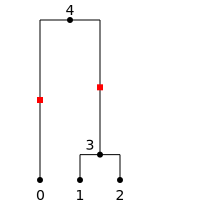

In [289]:
ts = msprime.simulate(3, mutation_rate=1)
tree = ts.first()
SVG(tree.draw())

In this example we have two mutations, shown by the red squares. Mutations occur above a given node in the tree, and all samples beneath this node will inherit the mutation. The infinite sites mutations used here are simple binary mutations, so that the ancestral state is 0 and the derived state is 1. One convenient way to access the resulting sample genotypes is to use the ``genotype_matrix()`` method, which returns an $m \times n$ numpy array, if we have $m$ variable sites and $n$ samples. Thus, if $G$ is the genotype matrix, $G[j, k]$ is the state of the $k$th sample at the $j$th site. In our example above, the site 0 has a mutation over node 0, site 1 has a mutation over node 3, and so we get the following matrix:

In [290]:
ts.genotype_matrix()

array([[1, 0, 0],
       [0, 1, 1]], dtype=uint8)

The genotype matrix is provides a convenient way of accessing this information, but will consume a great deal of memory for larger simulations. Msprime has an extensive suite of tools for efficiently working with sequence data and computing population genetics statistics, and a full review of these tools is beyond the scope of this document. Please consult the online documentation for more information on processing simulated sequences.

When comparing with analytical results regarding neutral genetic variation, it is very imporant to be aware of the way in which the mutation rates are defined in coalescent theory. For historical reasons, the scaled mutation rate $\theta$ is defined as $2N_e \mu$, where $\mu$ is the per-generation mutation rate. Since all times and rates are specified in units of generations in msprime, we must divide this factor of two out if we are to compare with analytical predictions. For example, the mean number of segregating sites for a sample of two is $\theta$; to run this in msprime we do the following:

In [284]:
N = 10000
theta = 5
S = np.zeros(N)
replicates = msprime.simulate(2, Ne=0.5, mutation_rate=theta / 2, num_replicates=N)
for j, ts in enumerate(replicates):
    S[j] = ts.num_sites  # Number of segregrating sites.
np.mean(S)

4.8853

Note that here we set the mutation rate to $\theta / 2$ (to cancel out the factor of 2 in the definition of $\theta$) and $N_e = 1/2$ (so that time is measured in haploid coalescent time units). Such factor-of-two gymnastics are unfortunately unavoidable in coalescent theory.

## Population structure

Explain multiple populations and migration


## Demographic events

How to specify demographic events and use the DemographyDebugger.

## Ancient samples

How to specify ancient samples.

## Recombination

How to specify recombination, and how to deal with the fact that we have a sequence of trees. Recombination maps. Also explain how we can get models with a fixed number of loci.